In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import ast

In [201]:
# read in exams
#exams = pd.read_csv('/Users/htr365/Documents/PhD/21_automatisation/gpt_eval/data/exam_approach/test_results/claude-3-7-sonnet-20250219/scores_67.csv')
exams = pd.read_csv('/Users/htr365/Documents/PhD/21_automatisation/gpt_eval/data/exam_approach/test_results/claude-3-7-sonnet-20250219/scores_mathematical_and_computational_occupations.csv')

exams.shape[0]

33

In [ ]:
# mark exams with empty entry, nan entry or key grade scores over 100 as invalid
exam_list.loc[exam_list['exam']=='','exam'] = 'Exam not valid'
exam_list['exam'] = exam_list['exam'].fillna('Exam not valid')
exam_list.loc[exam_list['key_grade']>100,'exam'] = 'Exam not valid'

<Axes: >

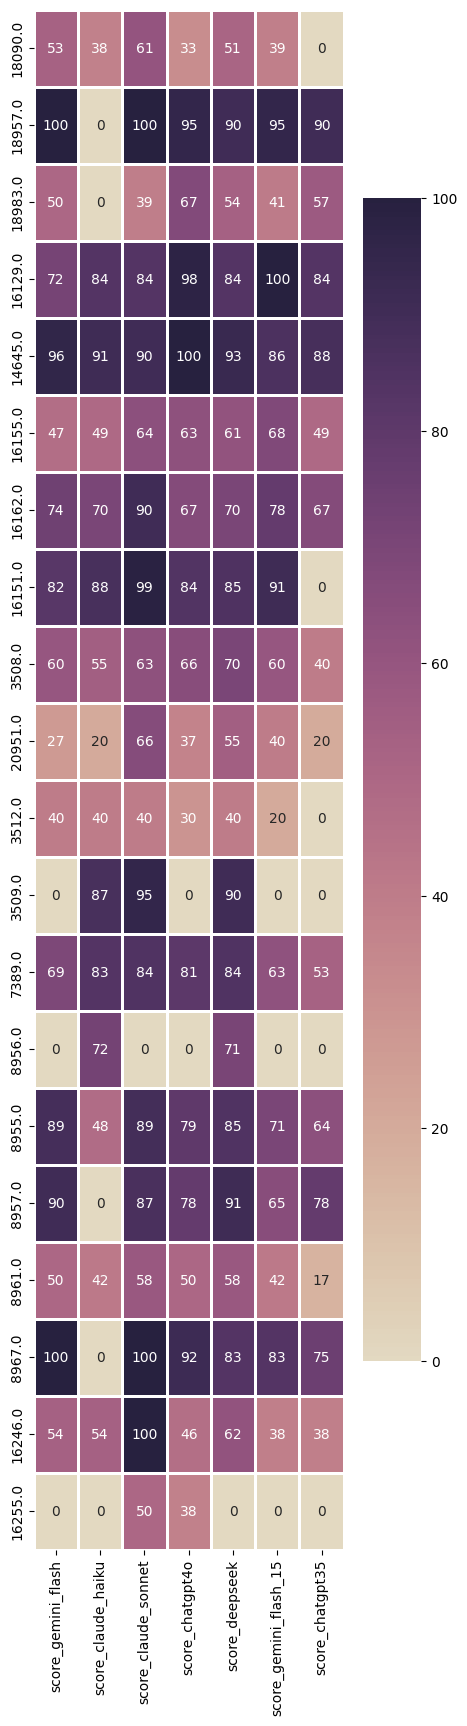

In [203]:
exams = exams[exams['exam'] !='Exam not valid']


score_cols = [col for col in df.columns if col.startswith('score')]
score_cols.append('task_id')
df_algorithms =exams[score_cols].copy()
df_algorithms = df_algorithms.fillna(0)

# Create the heatmap
plt.figure(figsize=(5, 20))

# Create the heatmap
sns.heatmap(
    df_algorithms.drop(columns='task_id'),  # Drop the occupation column from the data itself
    cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), annot=True,fmt=".0f", linewidths=1, linecolor='white',
    xticklabels=df_algorithms.columns[:-1],  # Exclude the 'occupation' column for x-ticks
    yticklabels=df_algorithms['task_id'],  # Use occupation as the y-tick labels
)

In [107]:
def convert_numeric(value):
    value = str(value).replace('%', '')  # Remove percentage sign
    value = float(value)  # Convert to float
    return int(value * 100) if value <=1 else int(value)  # Convert percentages to decimal format


Exam generated by  claude-3-7-sonnet-20250219


/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_17452/4018622914.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_algorithms = df_algorithms.fillna(0).applymap(convert_numeric)


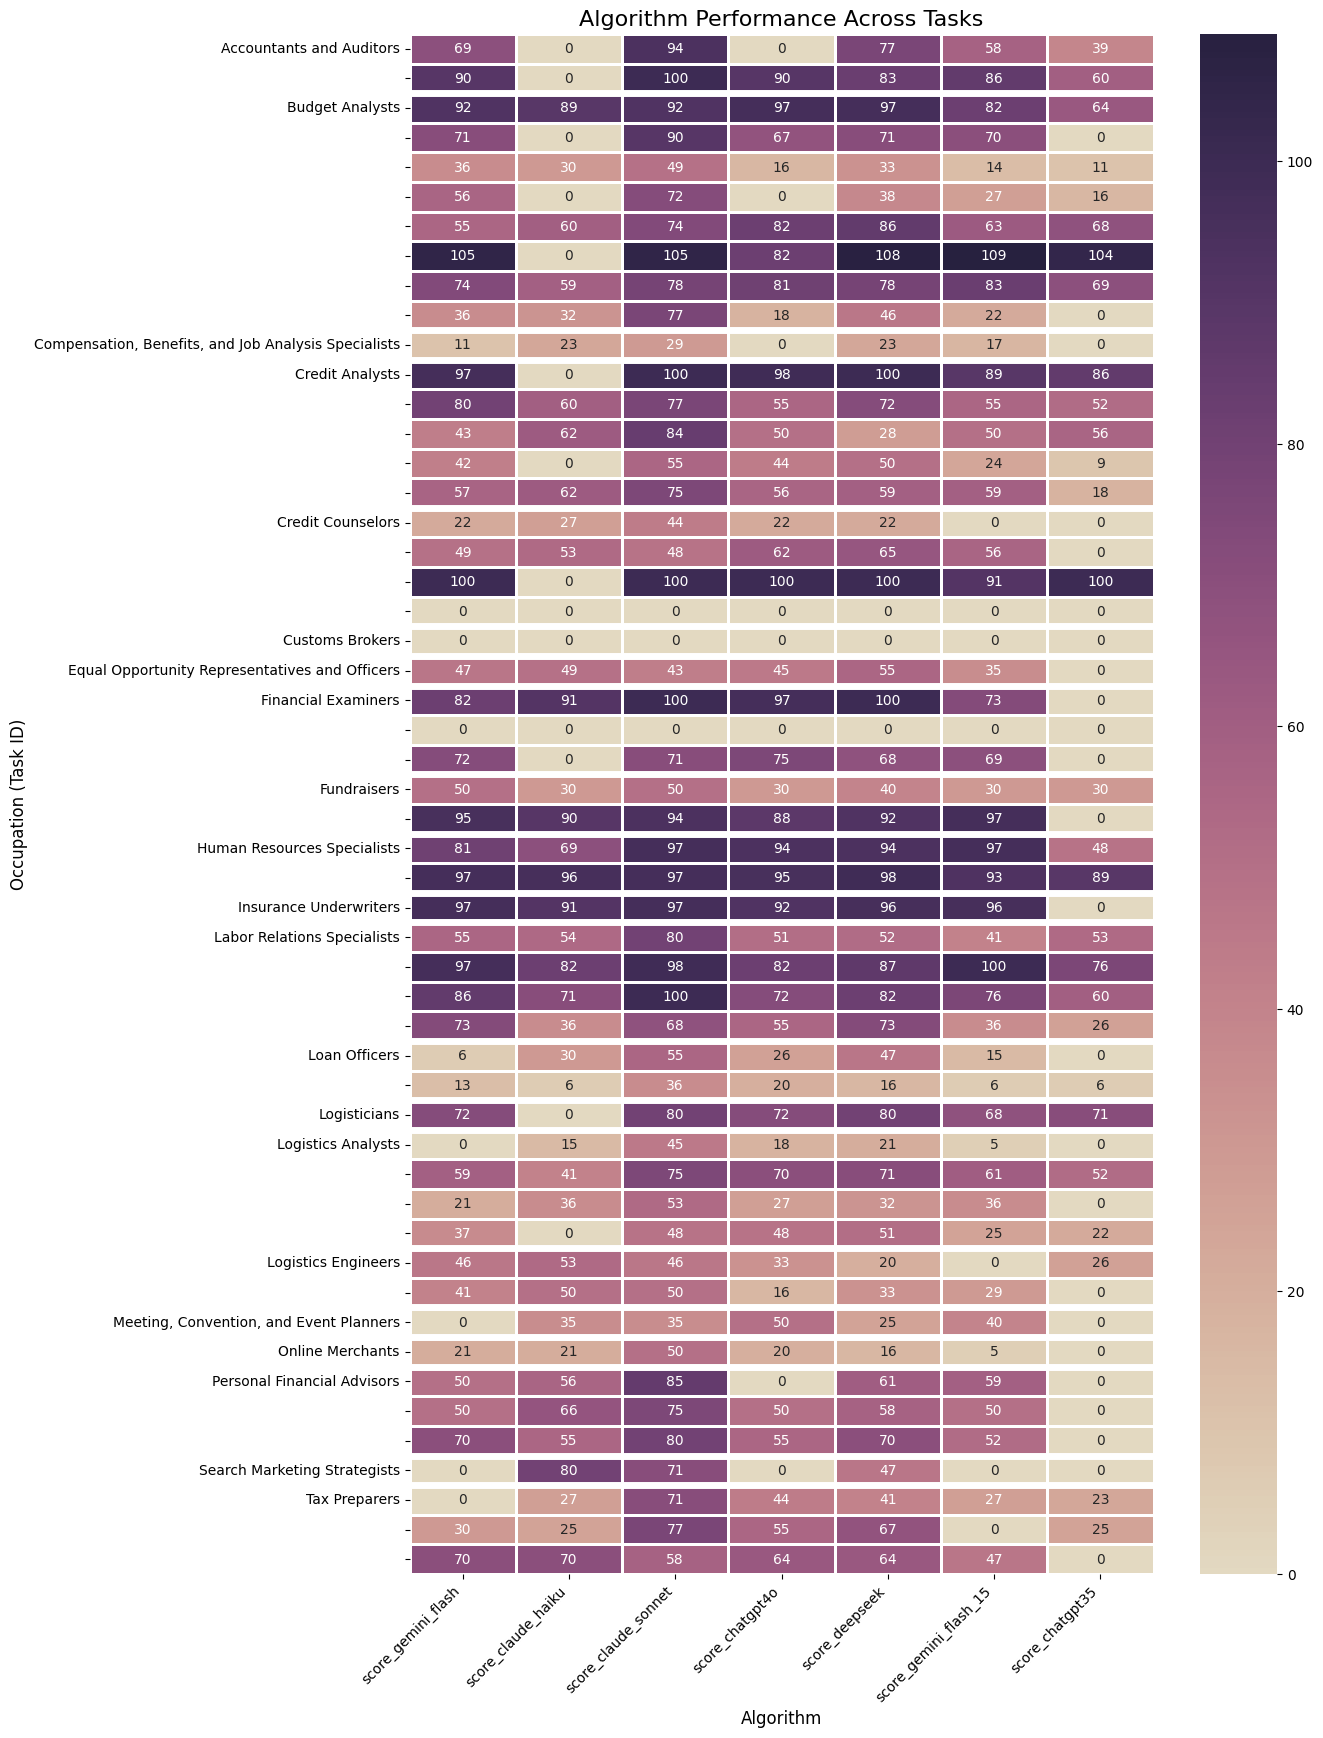

In [204]:
path_to_data = '../../data/exam_approach/test_results/'
#root, dirs, files = next(os.walk(path_to_data))
#for model in dirs:
model='claude-3-7-sonnet-20250219'
print('Exam generated by ', model)
df = pd.read_csv(os.path.join(path_to_data, model, 'scores_61.csv'),index_col=0)
df = df[df['exam'] !='Exam not valid']

# Sort dataframe by 'occupation' to group task IDs accordingly
df_sorted = df.sort_values(by='occupation')
# Group by 'occupation' and create a new column that indicates if the entry is the first in the group
df_sorted['is_first_in_group'] = df_sorted.groupby('occupation').cumcount() == 0


# Select only the algorithm score columns
#df_algorithms = df_sorted[['score_chatgpt35', 'score_chatgpt4o', 'score_claude', 'score_gemini', 'score_deepseek']].\
#rename(columns={'score_chatgpt35': 'GPT-3.5', 'score_chatgpt4o':'GPT-4o','score_claude':'Claude 3.7 Sonnet','score_deepseek':'DeepSeek Chat','score_gemini':'Gemini 2.0 Flash'})
score_cols = [col for col in df.columns if col.startswith('score')]
#score_cols.append('task_id')
df_algorithms = df_sorted[score_cols].copy()
# Handle missing values by filling them with 0 (or another method like forward-fill)
df_algorithms = df_algorithms.fillna(0).applymap(convert_numeric)


# Add a new column for occupation to use as row labels
df_algorithms['occupation'] = df_sorted['is_first_in_group'] * df_sorted['occupation']

# Create the heatmap
plt.figure(figsize=(12, 20))

# Create the heatmap
sns.heatmap(
    df_algorithms.drop(columns='occupation'),  # Drop the occupation column from the data itself
    cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), annot=True, fmt=".0f", linewidths=1, linecolor='white',
    xticklabels=df_algorithms.columns[:-1],  # Exclude the 'occupation' column for x-ticks
    yticklabels=df_algorithms['occupation'],  # Use occupation as the y-tick labels
)

# Now, let's add horizontal lines with different colors
ax = plt.gca()

# Iterate through the rows and add black lines for new occupation start
for i in range(1, len(df_algorithms)):
    if df_sorted['occupation'].iloc[i] != df_sorted['occupation'].iloc[i-1]:
        ax.axhline(i, color='white', linewidth=5)  # Add black horizontal line between occupations

# Add title and axis labels
plt.title("Algorithm Performance Across Tasks", fontsize=16)
plt.xlabel("Algorithm", fontsize=12)
plt.ylabel("Occupation (Task ID)", fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.show()


In [119]:
df_algorithms.drop('occupation', axis=1).mean(axis=0).sort_values(ascending=False)

score_claude_sonnet        57.836066
score_deepseek             49.065574
score_gemini_flash         44.311475
score_chatgpt4o            42.032787
score_claude_haiku         32.491803
score_chatgpt35            22.278689
score_gemini_flash_prev     6.081967
dtype: float64

In [109]:
# Define a function to split labels based on a character limit
def split_label(label, max_length=15):
    # Split the label into chunks of `max_length`
    words = label.split()
    lines = []
    current_line = []
    current_length = 0
    
    for word in words:
        # Check if adding this word exceeds the max length
        if current_length + len(word) + len(current_line) > max_length:
            # If it does, start a new line
            lines.append(" ".join(current_line))
            current_line = [word]
            current_length = len(word)
        else:
            # Otherwise, add the word to the current line
            current_line.append(word)
            current_length += len(word)
    
    # Add the last line
    if current_line:
        lines.append(" ".join(current_line))
    
    # Join the lines with '\n' for multi-line label
    return "\n".join(lines)

In [110]:
def get_tick_alignment(angle):
    if angle == 0:
        return "left",'center'
    if angle >= 0 and angle < np.pi/2:  # Right half
        return "left",'bottom'
    elif angle == np.pi/2:  # Top
        return "center", 'bottom'
    elif angle > np.pi/2 and angle < np.pi: # Left half
        return "right", 'bottom'
    elif angle == np.pi:
        return 'right','center'
    
    elif angle>np.pi and angle<3*np.pi/2:
        return 'right','top'
    elif angle==3*np.pi/2:
        return'center','top'
    elif angle>np.pi:
        return "left", 'top'


Exam generated by  claude-3-7-sonnet-20250219
Tax Preparers
Labor Relations Specialists
Logisticians
Logistics Engineers
Logistics Analysts
Meeting, Convention, and Event Planners
Fundraisers
Compensation, Benefits, and Job Analysis Specialists
Search Marketing Strategists
Online Merchants
Accountants and Auditors
Budget Analysts
Credit Analysts
Personal Financial Advisors
Insurance Underwriters
Financial Examiners
Equal Opportunity Representatives and Officers
Customs Brokers
Human Resources Specialists
Credit Counselors
Loan Officers


AttributeError: 'numpy.ndarray' object has no attribute 'legend'

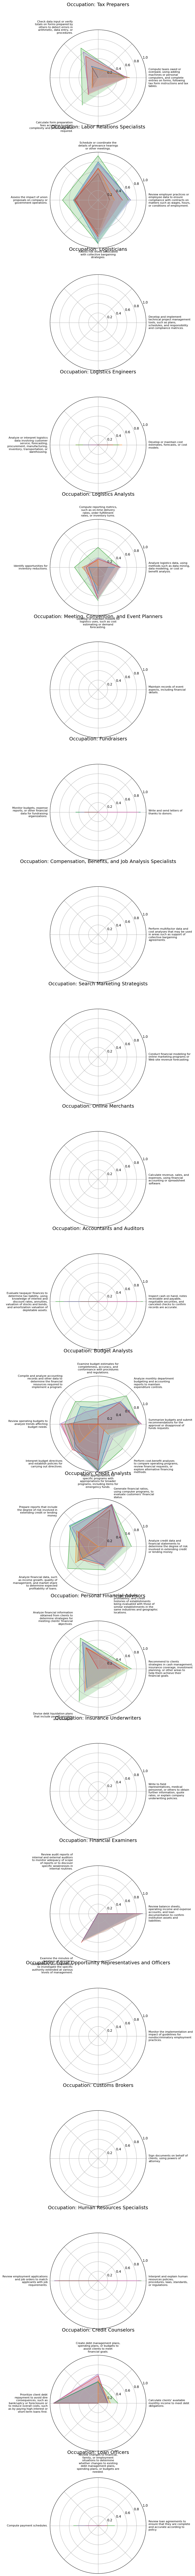

In [116]:
path_to_data = '../../data/exam_approach/test_results/'
# root, dirs, files = next(os.walk(path_to_data))
# for model in dirs:
model='claude-3-7-sonnet-20250219'
print('Exam generated by ', model)
df = pd.read_csv(os.path.join(path_to_data, model, 'scores_61.csv'),index_col=0)
df = df[df['exam'] !='Exam not valid']

score_cols = [col for col in df.columns if col.startswith('score')]
#score_cols.append('task_id')
df_radial_plot = df[score_cols].copy()
# df_radial_plot = df[['score_chatgpt35', 'score_chatgpt4o', 'score_claude', 'score_gemini', 'score_deepseek']].\
# rename(columns={'score_chatgpt35': 'GPT-3.5', 'score_chatgpt4o':'GPT-4o','score_claude':'Claude 3.7 Sonnet','score_deepseek':'DeepSeek Chat','score_gemini':'Gemini 2.0 Flash'}).fillna(0).applymap(convert_numeric)
# print(df_radial_plot.shape[0])
df_radial_plot = pd.concat([df[['occupation','task_description']], df_radial_plot], axis=1)
# Assuming df_algorithms contains the task descriptions and model scores
#models = ['GPT-3.5', 'GPT-4o', 'Claude 3.7 Sonnet', 'Gemini 2.0 Flash',
 #   'DeepSeek Chat']# 1. Get unique occupations
occupations = df['occupation'].unique()
models=score_cols
df_radial_plot = df_radial_plot.fillna(0)
# 2. Create the figure with subplots, one for each occupation
fig, axes = plt.subplots(nrows=len(occupations), figsize=(10, len(occupations) * 5), subplot_kw={'projection': 'polar'})
fig.tight_layout(h_pad=4)

min_scale = df_radial_plot[models].min().min()
max_scale = df_radial_plot[models].max().max()
# Loop through each occupation and create a radial plot for each
for i, occupation in enumerate(occupations):
    print(occupation)
    # Get the data for the current occupation
    occupation_data = df_radial_plot[df_radial_plot['occupation'] == occupation]
    
    # Create an axis for the current subplot (using polar projection)
    ax = axes[i] if len(occupations) > 1 else axes
    
    # Set title for the subplot
    ax.set_title(f"Occupation: {occupation}", fontsize=14, pad=70)

    # Set the number of tasks (this will determine the number of angular divisions)
    num_tasks = len(occupation_data)
    angles = np.linspace(0, 2 * np.pi, num_tasks, endpoint=False)  # Angles for each task
    
    # Loop through each model and plot its data in radial form
    for j, model in enumerate(models):
        scores = occupation_data[model].values  # y-axis (model score)
        scores_normalized = np.interp(scores, (min_scale, max_scale), (0, 1))  # Normalize
        # Plot each model with the filled area
        ax.fill(angles, scores_normalized, alpha=0.2, label='', zorder=1)
        ax.plot(angles, scores_normalized, label=model if i == 0 else "", alpha=0.7)
    
    # Set the angular ticks to be task descriptions
        #ax.set_xticks(angles)
        ax.set_xticklabels([])

    # Split the labels into multiple lines
    new_labels = [split_label(label, max_length=30) for label in occupation_data['task_description']]
    
    # Set the xticklabels only once
    #ax.set_xticklabels(new_labels, fontsize=8, rotation=45, ha='right')

    # Customize tick label alignment based on angle
    for angle, label in zip(angles, new_labels):
        ha, va = get_tick_alignment(angle)  # Get horizontal and vertical alignment based on angle
        ax.text(angle, 1.05, label, horizontalalignment=ha, verticalalignment=va, fontsize=8, color="black", zorder=2)

    ax.set_ylim(0, 1)  # Set radial limits (0 to 1 after normalization)

# Add legend only once (at the end), broken into multiple rows
axes.legend(
    loc='lower center',
    fontsize=10,  # Legend font size
    ncol=2,  # Number of columns in the legend
    title="Models",  # Legend title
    bbox_to_anchor=(.5, -.9)
)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()